In [3]:
# Importing the required packages
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
# Separating the data into labels and features
labels, data = data['emotion'], data.drop(['emotion','Usage'], axis=1)
data.head()

,pixels
0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,151 150 147 155 148 133 111 140 170 174 182 15...
2,231 212 156 164 174 138 161 173 182 200 106 38...
3,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [6]:
# Here we will use only the first 2000 images for denoising
data = data[0:2000]
labels = labels[0:2000]

## Visualizing the Original Images to be Denoised / Reconstructed


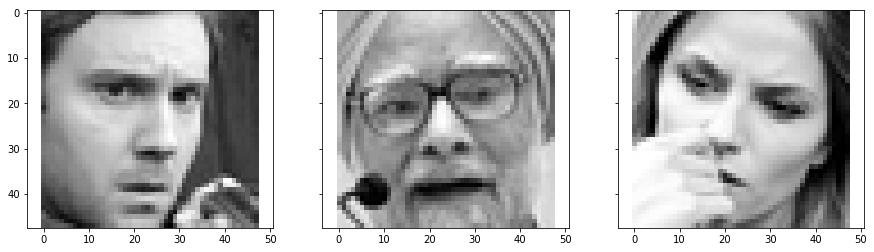

In [7]:
# Taking in the pixels of image i.e the features as a numpy array
pixel_data = data.values
pixel_data = pixel_data.astype(str)
pixel_data = np.core.defchararray.rsplit(pixel_data, sep=None, maxsplit=None)

# Visualizing the images using matplotlib
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(15,4))

for x in range(len(axes)):
    first_row = np.asarray((pixel_data)[x][0]).astype('float32')
    vis_image = first_row.reshape(48,48)
    axes[x].imshow(vis_image,cmap='gray')

In [13]:
# For the original images
# Defining an empty list to hold values
image_data = []
# Here we parse through each element in pixel_data, extract and reshape the images and then finally resize it appropriately
for i in range(len(pixel_data)):
    row_data = np.asarray((pixel_data)[i][0]).astype('float32')
    # Normalizing the data to a value between 0 and 1
    row_data = row_data/255.0
    reshaped_row_data = row_data.reshape(48,48)
    image_data.append(reshaped_row_data)
big_data = np.vstack(image_data)

final_data = big_data.reshape(2000, 48, 48, 1)
final_data.shape

(2000, 48, 48, 1)

Now in order to use an autoencoder to reconstruct the images we will need to provide two types of inputs to the autoencoder :
the original images, and some noisy images. So, in the next block I will be adding some random noise to each image 

In [8]:
from skimage.util import random_noise

# For the noisy images
noisy_image_data = []
for i in range(len(pixel_data)):
    row_data = np.asarray((pixel_data)[i][0]).astype('float32')
    # Normalizing the data to a value between 0 and 1 and then rescaling it to a value between -1 and 1
    row_data = row_data/255.0
    row_data = 2*row_data - 1
    reshaped_row_data = row_data.reshape(48,48)
    # Adding random gaussian noise to the source images so that they can be reconstructed from scratch
    reshaped_noisy_data = random_noise(reshaped_row_data, mode='gaussian', clip=True)
    noisy_image_data.append(reshaped_noisy_data)
noisy_data = np.vstack(noisy_image_data)
noisy_data = noisy_data.reshape(2000, 48, 48, 1)
noisy_data.shape

(2000, 48, 48, 1)

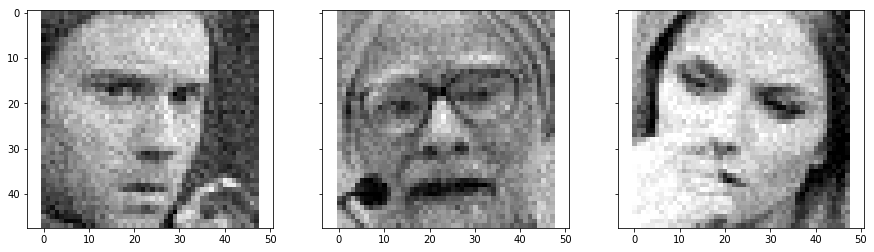

In [11]:
# Visualizing the noisy images using matplotlib
fig2, axes2 = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(15,4))

for x in range(len(axes2)):
    noisy_image = np.asarray((noisy_data)[x]).astype('float32')
    noisy_reshaped_data = noisy_image.reshape(48, 48)
    axes2[x].imshow(noisy_reshaped_data,cmap='gray')

## Building the Autoencoder Network

The type of autoencoder that we are going to use here is a deep convolutional autoencoder. This autoencoder consists of two networks : one for encoding the image and the other for reconstructing the image. These networks are the convolutional and deconvolutional networks respectively. Below I have implemented this architecture using tensorflow.

In [14]:
# Initializing placeholders using tensorflow
noisy_input_images = tf.placeholder(tf.float32, [None, 48, 48, 1], name='inputs')
original_target_images = tf.placeholder(tf.float32, [None, 48, 48, 1], name='targets')